# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Installing Libraries

In [ ]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0
# %pip install evaluate
# %pip install wandb
# %pip install huggingface_hub
# %pip install torch==2.5.0 torchvision==0.20.0 --index-url https://download.pytorch.org/whl/cu121

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

import wandb

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

### Load Training and Testing Data

### Secret

In [ ]:
# from datasets import load_dataset, DatasetDict
# from datasets import Image

# column_names = ["image_id", "label"]
# data_files_2016 = {"train": "datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv"}
# data_files_2017 = {"train": "datasets/ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv"}

# dataset2016 = load_dataset("csv", data_files=data_files_2016, column_names=column_names)

# image_directory = "datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data/"

# def load_images(example):
#     example["image"] = f"{image_directory}{example['image_id']}"  
#     return example

# dataset = dataset["train"].map(load_images)
# dataset = dataset.cast_column("image", Image())
# dataset

KeyError: "Column train not in the dataset. Current columns in the dataset: ['image_id', 'label', 'image']"

In [ ]:
#smote images
def create_image_dataframe(base_dir):
    image_ids = []
    labels = []
    file_paths = []

    for label in ['0', '1']: 
        label_dir = os.path.join(base_dir, label)
        for image_name in os.listdir(label_dir):
            if image_name.endswith(".jpg"): 
                image_id = image_name.split('.')[0]
                image_ids.append(image_id)
                labels.append(int(label))
                file_path = os.path.join(label_dir, image_name)
                file_paths.append(file_path)

    df = pd.DataFrame({
        'image_id': image_ids,
        'label': labels,
        'file_path': file_paths,
    })
    
    return df
base_dir = 'datasets/ISIC2016/smote_images'
#train_labels_df = create_image_dataframe(base_dir)

### 2016 Dataframe

In [2]:
def process_dataset(csv_file, image_dir, label_map):
    labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])
    labels_df['label'] = labels_df['label'].map(label_map)
    labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    return labels_df

label_map_train = {'benign': 0, 'malignant': 1}
label_map_test = {0.0: 0, 1.0: 1}

train_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
train_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'

test_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
test_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Data'

train_labels_df_2016 = process_dataset(train_csv_file, train_image_dir, label_map_train)
test_labels_df_2016 = process_dataset(test_csv_file, test_image_dir, label_map_test)
validation_labels_df_2016, test_labels_df_2016 = train_test_split(test_labels_df_2016, test_size=0.5, random_state=42)

print(train_labels_df_2016.head())

       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...


### 2017 Dataframe

In [3]:
def process_dataset(csv_file, image_dir, label_map):
    labels_df = pd.read_csv(csv_file)
    labels_df = labels_df.drop(columns=['seborrheic_keratosis'])
    labels_df = labels_df.rename(columns={'melanoma': 'label'}) 
    labels_df['label'] = labels_df['label'].map(label_map)
    labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    return labels_df

label_map = {0.0: 0, 1.0: 1}

train_csv_file = 'datasets/ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv'
train_image_dir = 'datasets/ISIC2017/ISIC-2017_Training_Data'

validation_csv_file = 'datasets/ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
validation_image_dir = 'datasets/ISIC2017/ISIC-2017_Validation_Data'

test_csv_file = 'datasets/ISIC2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
test_image_dir = 'datasets/ISIC2017/ISIC-2017_Test_v2_Data'

train_labels_df_2017 = process_dataset(train_csv_file, train_image_dir, label_map)
test_labels_df_2017 = process_dataset(test_csv_file, test_image_dir, label_map)
validation_labels_df_2017 = process_dataset(validation_csv_file, validation_image_dir, label_map)

print(train_labels_df_2017.head())


       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
1  ISIC_0000001      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
2  ISIC_0000002      1  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
3  ISIC_0000003      0  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...
4  ISIC_0000004      1  datasets/ISIC2017/ISIC-2017_Training_Data\ISIC...


### Merge Dataframes

In [4]:
merged_df = pd.merge(train_labels_df_2016, train_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))
merged_df_validation = pd.merge(validation_labels_df_2016, validation_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))
merged_df_test = pd.merge(test_labels_df_2016, test_labels_df_2017, on='image_id', how='outer', suffixes=('_1', '_2'))

merged_df['label'] = merged_df['label_1'].fillna(merged_df['label_2']).astype(int)
merged_df['file_path'] = merged_df['file_path_1'].fillna(merged_df['file_path_2'])
merged_df_validation['label'] = merged_df_validation['label_1'].fillna(merged_df_validation['label_2']).astype(int)
merged_df_validation['file_path'] = merged_df_validation['file_path_1'].fillna(merged_df_validation['file_path_2'])
merged_df_test['label'] = merged_df_test['label_1'].fillna(merged_df_test['label_2']).astype(int)
merged_df_test['file_path'] = merged_df_test['file_path_1'].fillna(merged_df_test['file_path_2'])

final_df = merged_df[['image_id', 'label', 'file_path']]
final_df_validation = merged_df_validation[['image_id', 'label', 'file_path']]
final_df_test = merged_df_test[['image_id', 'label', 'file_path']]

### Dataset Characterization and Visualization

In [5]:
def characterize_dataset(df):
    print("DataFrame Shape:", df.shape)
    print("\nDataFrame Info:")
    print(df.info())
    print("\nColumn Names:")
    print(df.columns.tolist())
    print("\nNull Values Count:")
    print(df.isnull().sum())
    print("\nLabel Distribution:")
    print(df['label'].value_counts(dropna=False))
    print("\nFirst few rows:")
    print(df.head())
    print("\nNumber of duplicate image_ids:", df['image_id'].duplicated().sum())

    widths, heights = [], []
    class_counts = df['label'].value_counts()
    
    for idx, row in df.iterrows():
        image = Image.open(row['file_path'])
        widths.append(image.size[0])
        heights.append(image.size[1])
    
    plt.figure(figsize=(5, 3))
    plt.hist2d(widths, heights, bins=60, cmap='viridis')
    plt.colorbar(label='Number of Images')
    plt.title("Distribution of Image Sizes")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

Train
DataFrame Shape: (2154, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2154 entries, 0 to 2153
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   2154 non-null   object
 1   label      2154 non-null   int32 
 2   file_path  2154 non-null   object
dtypes: int32(1), object(2)
memory usage: 58.9+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    1754
1     400
Name: label, dtype: int64

First few rows:
       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_000

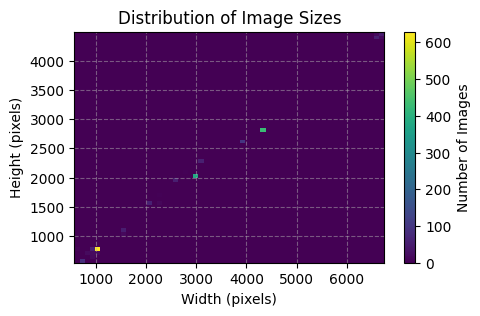

Validation
DataFrame Shape: (339, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 338
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   339 non-null    object
 1   label      339 non-null    int32 
 2   file_path  339 non-null    object
dtypes: int32(1), object(2)
memory usage: 9.3+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    272
1     67
Name: label, dtype: int64

First few rows:
       image_id  label                                          file_path
0  ISIC_0000040      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
1  ISIC_0010231      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
2  ISIC_0009889      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
3  ISIC_0009980      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
4  ISIC_0000

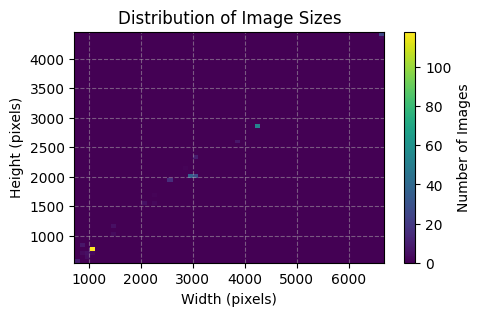

Test
DataFrame Shape: (790, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 789
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   790 non-null    object
 1   label      790 non-null    int32 
 2   file_path  790 non-null    object
dtypes: int32(1), object(2)
memory usage: 21.6+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    635
1    155
Name: label, dtype: int64

First few rows:
       image_id  label                                          file_path
0  ISIC_0010451      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
1  ISIC_0010379      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
2  ISIC_0011092      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
3  ISIC_0001685      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
4  ISIC_0000202  

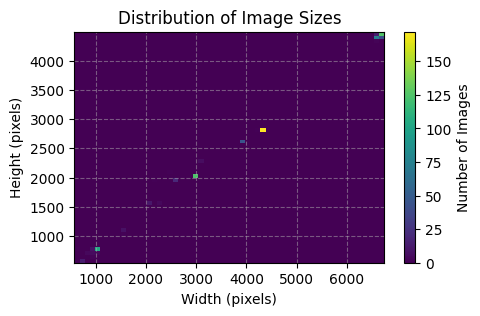

In [6]:
print("Train")
characterize_dataset(final_df)
print("Validation")
characterize_dataset(final_df_validation)
print("Test")
characterize_dataset(final_df_test)

### Plotting Samples


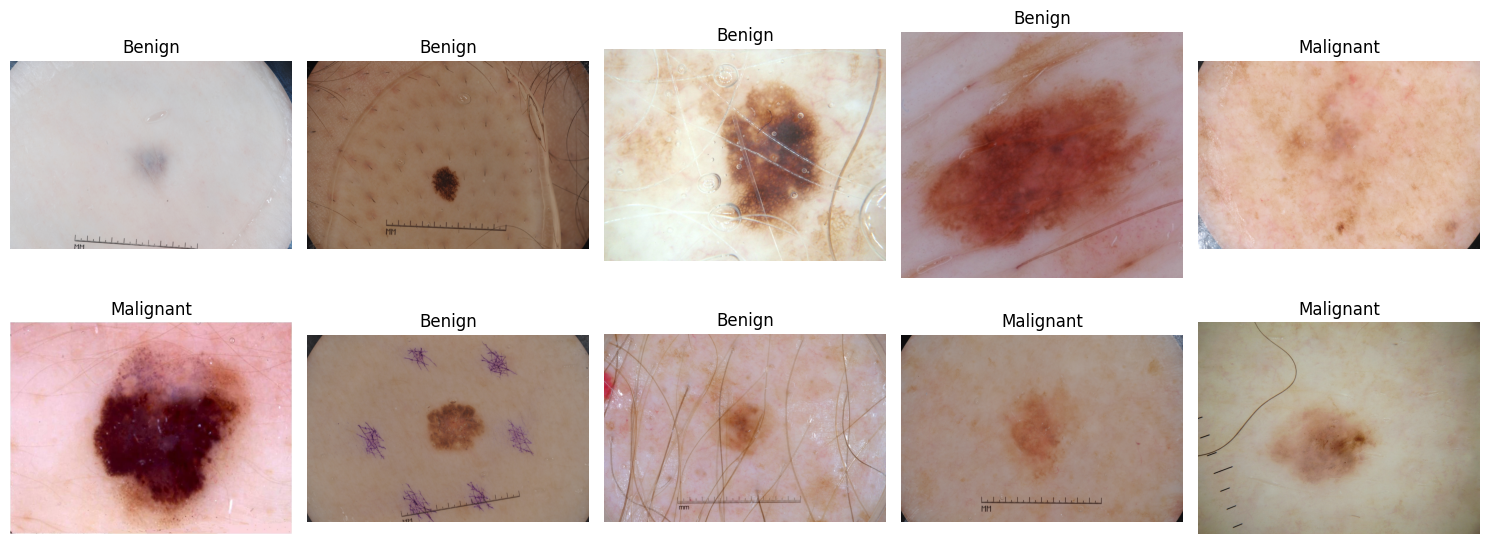

In [7]:
def plot_samples(labels_df, rows=2, cols=5, processor=None):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    sampled_df = labels_df.sample(n=rows * cols, random_state=42)
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['file_path']
        label = row['label']
        
        image = Image.open(image_path).convert("RGB")
        
        if processor:
            image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).permute(1, 2, 0).numpy()
        else:
            image = np.array(image)

        axes[i].imshow(image)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')  # Set title based on the label
        axes[i].axis('off')  # Turn off axes
    plt.tight_layout()
    plt.show()

plot_samples(final_df)
# plot_samples(validation_labels_df)

# Data Augmentation

DataFrame Shape: (1200, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   1200 non-null   object
 1   label      1200 non-null   int64 
 2   file_path  1200 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.3+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
1    1200
Name: label, dtype: int64

First few rows:
         image_id  label                                          file_path
0  ISIC_0000002_0      1  datasets/temp/augmented_images/ISIC_0000002_0.jpg
1  ISIC_0000002_1      1  datasets/temp/augmented_images/ISIC_0000002_1.jpg
2  ISIC_0000002_2      1  datasets/temp/augmented_images/ISIC_0000002_2.jpg
3  ISIC_0000004_0      1  datasets/temp/augmented_images/ISIC_0000004_0.jpg
4  ISIC_0000004_1

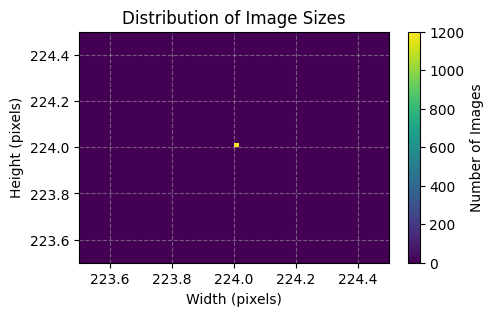

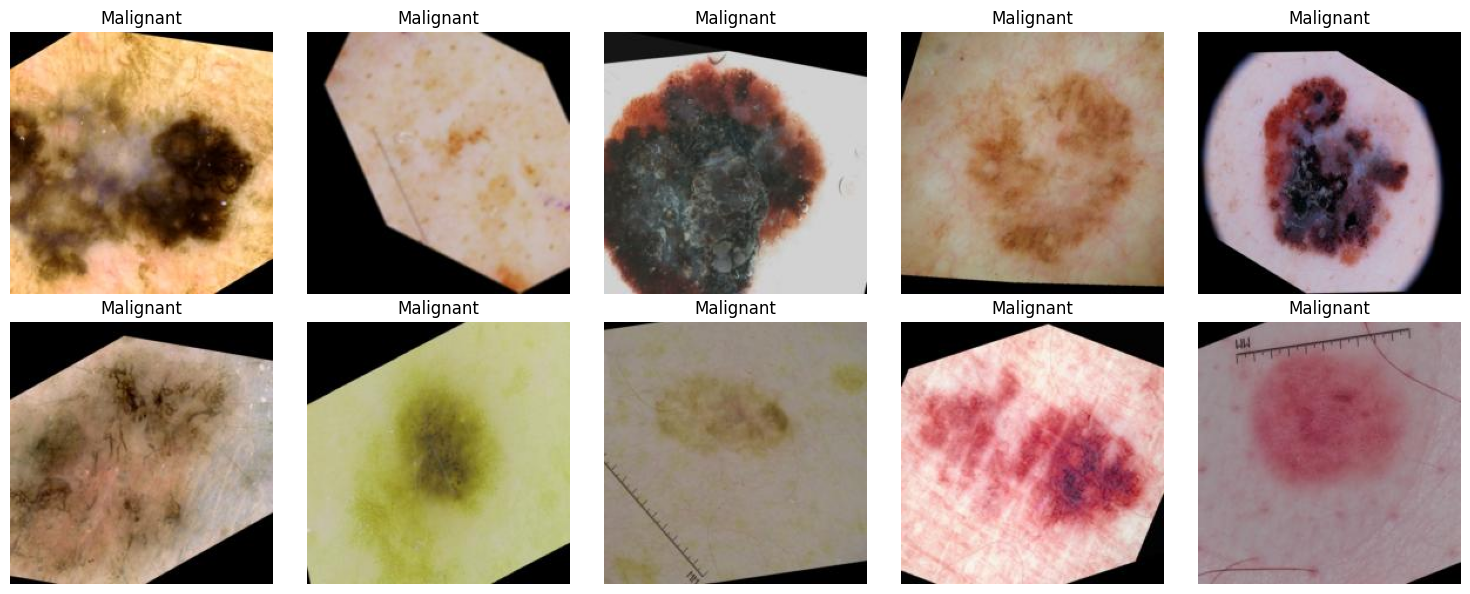

In [8]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=15
    ),
    transforms.RandomResizedCrop(
        224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
])

def augment_malignant_samples(df, augmentations, augmentation_factor=4):
    malignant_df = df[df['label'] == 1]  # Select malignant (1) samples
    augmented_samples = []

    for idx, row in malignant_df.iterrows():
        img_path = row['file_path']
        label = row['label']
        image_id = row['image_id']
        
        image = Image.open(img_path).convert('RGB')
        
        for _ in range(augmentation_factor):
            augmented_image = augmentations(image)
            augmented_image.save(f"datasets/temp/augmented_images/{image_id}_{_}.jpg")
            augmented_samples.append({'image_id': f"{image_id}_{_}",'label': label, 'file_path': f"datasets/temp/augmented_images/{image_id}_{_}.jpg"})
    
    # Convert the augmented samples into a DataFrame
    augmented_df = pd.DataFrame(augmented_samples)
    return augmented_df

image_dir = "datasets/temp/augmented_images/"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  # Adjust extension if needed

data = []
for image_file in image_files:
    image_id = image_file.split('.')[0]  
    label = 1 
    
    data.append({
        'image_id': image_id, 
        'label': label,
        'file_path': os.path.join(image_dir, image_file)
    })

# Create the DataFrame
#augmented_malignant_df = augment_malignant_samples(final_df, augmentations, augmentation_factor=3)
augmented_malignant_df = pd.DataFrame(data)
characterize_dataset(augmented_malignant_df)
plot_samples(augmented_malignant_df)


DataFrame Shape: (3354, 3)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3354 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   3354 non-null   object
 1   label      3354 non-null   int64 
 2   file_path  3354 non-null   object
dtypes: int64(1), object(2)
memory usage: 104.8+ KB
None

Column Names:
['image_id', 'label', 'file_path']

Null Values Count:
image_id     0
label        0
file_path    0
dtype: int64

Label Distribution:
0    1754
1    1600
Name: label, dtype: int64

First few rows:
       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006 

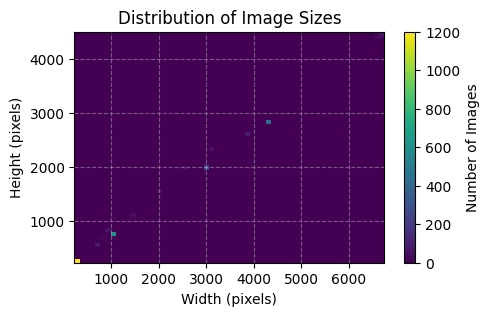

In [9]:
final_df_training = pd.concat([final_df, augmented_malignant_df], axis=0)
characterize_dataset(final_df_training)

In [ ]:
dataset_dict = DatasetDict({
    "train": final_df_training,
    "validation": final_df_validation,
    "test": final_df_test
})

# dataset_dict.push_to_hub("cs198-cvmig/isic2016-2017_augmented_224")

dataset_dict

DatasetDict({
    train:             image_id  label                                          file_path
    0       ISIC_0000000    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    1       ISIC_0000001    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    2       ISIC_0000002    1.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    3       ISIC_0000004    1.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    4       ISIC_0000006    0.0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
    ...              ...    ...                                                ...
    1195  ISIC_0015219_1    1.0  datasets/temp/augmented_images/ISIC_0015219_1.jpg
    1196  ISIC_0015219_2    1.0  datasets/temp/augmented_images/ISIC_0015219_2.jpg
    1197  ISIC_0015284_0    1.0  datasets/temp/augmented_images/ISIC_0015284_0.jpg
    1198  ISIC_0015284_1    1.0  datasets/temp/augmented_images/ISIC_0015284_1.jpg
    1199  ISIC_0015284_2    1.0  datasets/temp/augmented_images/IS

# Classification using Vision Transformers

### Defining Dataset for ViT

In [10]:
class ISICDatasetTransform(Dataset):
    def __init__(self, labels_df, processor=None):
        self.labels_df = labels_df
        self.processor = processor

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        label = row['label']
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        
        return inputs

### Loading Model and Processor

In [12]:
def load_model_and_processor(model_name):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes = True
    )
    for name,p in model.named_parameters():
        if not name.startswith('classifier'):
            p.requires_grad = False

    num_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

    print(f"{num_params = :,} | {trainable_params = :,}")

    return model, processor

### Data Collator Function

In [13]:
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

### Metric Computation for Evaluation

In [14]:
from sklearn.metrics import recall_score, confusion_matrix, average_precision_score, roc_auc_score, accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, axis=1).numpy()  # Get predicted classes
    probabilities = torch.softmax(logits, dim=1)[:, 1].numpy()  # Probabilities for class 1

    # Accuracy
    accuracy_score_value = accuracy_score(labels, predictions)
    
    # Sensitivity (Recall for positive class)
    sensitivity_score = recall_score(labels, predictions, pos_label=1)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity_score = tn / (tn + fp)
    
    # Average Precision
    avg_precision = average_precision_score(labels, probabilities)
    
    # AUC-ROC
    auc_score = roc_auc_score(labels, probabilities)

    wandb.log({
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    })
    
    return {
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    }

## Model Training and Evaluation

### Ready Results

In [15]:
import json
output_file = './output/model_comparison.json'
try:
    with open(output_file, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    results = {}

### Training Loop

In [16]:
import torch
wandb.init(project='skin_cancer_detection')
model_name = "google/vit-base-patch16-224" # "google/vit-large-patch16-224", "google/vit-base-patch16-384"
unique_model_name = f'{model_name.replace("/","-")}_isic2016-2017_augmented'

# Load model and processor
model, processor = load_model_and_processor(model_name)

# Prepare dataset with processor's transformations
train_dataset = ISICDatasetTransform(final_df_training, processor)
eval_dataset = ISICDatasetTransform(final_df_validation, processor)
test_dataset = ISICDatasetTransform(final_df_test, processor)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir=f'./results/{unique_model_name}',
    hub_model_id=f'cs198-cvmig/{unique_model_name}',
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='wandb',
    load_best_model_at_end=True,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
)

# Train and evaluate
print(f"Training and evaluating model: {model_name}")
trainer.train(resume_from_checkpoint=False) # Set to True to resume training
eval_results = trainer.evaluate(test_dataset)
results[unique_model_name] = eval_results

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wtmaceda (wtmaceda-university-of-the-philippines-diliman). Use `wandb login --relogin` to force relogin


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_params = 85,800,194 | trainable_params = 1,538


C:\Users\win10\AppData\Local\Temp\ipykernel_8204\3610997134.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training and evaluating model: google/vit-base-patch16-224


 10%|▉         | 100/1050 [02:30<34:32,  2.18s/it]

{'loss': 0.4229, 'grad_norm': 2.9489829540252686, 'learning_rate': 0.0002714285714285714, 'epoch': 0.48}


 19%|█▉        | 200/1050 [04:49<23:10,  1.64s/it]

{'loss': 0.3234, 'grad_norm': 2.040231704711914, 'learning_rate': 0.00024285714285714283, 'epoch': 0.95}


                                                  
 20%|██        | 210/1050 [05:47<13:34,  1.03it/s]

{'eval_loss': 0.4359703063964844, 'eval_accuracy': 0.8171091445427728, 'eval_sensitivity': 0.1044776119402985, 'eval_specificity': 0.9926470588235294, 'eval_average_precision': 0.4620788588243505, 'eval_auc_roc': 0.7586150131694468, 'eval_runtime': 46.0994, 'eval_samples_per_second': 7.354, 'eval_steps_per_second': 0.933, 'epoch': 1.0}


 29%|██▊       | 300/1050 [08:00<22:16,  1.78s/it]  

{'loss': 0.2684, 'grad_norm': 2.5599677562713623, 'learning_rate': 0.00021428571428571427, 'epoch': 1.43}


 38%|███▊      | 400/1050 [10:28<16:05,  1.49s/it]

{'loss': 0.2911, 'grad_norm': 2.433072328567505, 'learning_rate': 0.00018571428571428572, 'epoch': 1.9}


                                                  
 40%|████      | 420/1050 [11:45<09:57,  1.05it/s]

{'eval_loss': 0.40810030698776245, 'eval_accuracy': 0.8112094395280236, 'eval_sensitivity': 0.2537313432835821, 'eval_specificity': 0.9485294117647058, 'eval_average_precision': 0.5287796928896037, 'eval_auc_roc': 0.7876975417032486, 'eval_runtime': 44.903, 'eval_samples_per_second': 7.55, 'eval_steps_per_second': 0.958, 'epoch': 2.0}


 48%|████▊     | 500/1050 [13:48<08:57,  1.02it/s]  

{'loss': 0.2847, 'grad_norm': 2.008981227874756, 'learning_rate': 0.00015714285714285713, 'epoch': 2.38}


 57%|█████▋    | 600/1050 [16:13<10:06,  1.35s/it]

{'loss': 0.2492, 'grad_norm': 2.580894708633423, 'learning_rate': 0.00012857142857142855, 'epoch': 2.86}


                                                  
 60%|██████    | 630/1050 [17:40<06:09,  1.14it/s]

{'eval_loss': 0.39862799644470215, 'eval_accuracy': 0.8171091445427728, 'eval_sensitivity': 0.2537313432835821, 'eval_specificity': 0.9558823529411765, 'eval_average_precision': 0.5598823680763902, 'eval_auc_roc': 0.7965320456540825, 'eval_runtime': 45.6784, 'eval_samples_per_second': 7.421, 'eval_steps_per_second': 0.941, 'epoch': 3.0}


 67%|██████▋   | 700/1050 [19:27<08:29,  1.46s/it]  

{'loss': 0.2582, 'grad_norm': 1.3534985780715942, 'learning_rate': 9.999999999999999e-05, 'epoch': 3.33}


 76%|███████▌  | 800/1050 [21:47<07:48,  1.87s/it]

{'loss': 0.2468, 'grad_norm': 1.6573801040649414, 'learning_rate': 7.142857142857142e-05, 'epoch': 3.81}


                                                  
 80%|████████  | 840/1050 [23:33<04:15,  1.22s/it]

{'eval_loss': 0.3929111957550049, 'eval_accuracy': 0.8200589970501475, 'eval_sensitivity': 0.3283582089552239, 'eval_specificity': 0.9411764705882353, 'eval_average_precision': 0.5762988380387806, 'eval_auc_roc': 0.8026229148375769, 'eval_runtime': 44.5539, 'eval_samples_per_second': 7.609, 'eval_steps_per_second': 0.965, 'epoch': 4.0}


 86%|████████▌ | 900/1050 [25:10<03:42,  1.48s/it]

{'loss': 0.2601, 'grad_norm': 2.1082468032836914, 'learning_rate': 4.285714285714285e-05, 'epoch': 4.29}


 95%|█████████▌| 1000/1050 [27:27<01:01,  1.23s/it]

{'loss': 0.2536, 'grad_norm': 2.5302951335906982, 'learning_rate': 1.4285714285714284e-05, 'epoch': 4.76}


                                                   
100%|██████████| 1050/1050 [29:28<00:00,  1.04it/s]

{'eval_loss': 0.3942181169986725, 'eval_accuracy': 0.8289085545722714, 'eval_sensitivity': 0.22388059701492538, 'eval_specificity': 0.9779411764705882, 'eval_average_precision': 0.5790886316874709, 'eval_auc_roc': 0.8026777875329236, 'eval_runtime': 45.342, 'eval_samples_per_second': 7.477, 'eval_steps_per_second': 0.948, 'epoch': 5.0}


100%|██████████| 1050/1050 [29:30<00:00,  1.69s/it]


{'train_runtime': 1770.7318, 'train_samples_per_second': 9.471, 'train_steps_per_second': 0.593, 'train_loss': 0.28420269103277296, 'epoch': 5.0}


100%|██████████| 99/99 [03:38<00:00,  2.21s/it]


accuracy,▄▃▄▅█▁
auc_roc,▄▇▇██▁
average_precision,▃▆▇██▁
eval/accuracy,▄▃▄▅█▁
eval/auc_roc,▄▇▇██▁
eval/average_precision,▃▆▇██▁
eval/loss,▆▃▂▁▁█
eval/runtime,▁▁▁▁▁█
eval/samples_per_second,█████▁
eval/sensitivity,▁▆▆█▅█
eval/specificity,█▄▄▃▇▁


### Results for Comparison

In [17]:
# Print out the results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("\n")


# Save the results in JSON format
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_file}")

Model: google/vit-base-patch16-224
  eval_loss: 0.5098
  eval_accuracy: 0.7684
  eval_sensitivity: 0.4474
  eval_specificity: 0.8487
  eval_average_precision: 0.4467
  eval_auc_roc: 0.7280
  eval_runtime: 9.4985
  eval_samples_per_second: 20.0030
  eval_steps_per_second: 2.5270
  epoch: 5.0000


Model: google-vit-base-patch16-224_isic2016-2017_augmented
  eval_loss: 0.4536
  eval_accuracy: 0.8063
  eval_sensitivity: 0.3290
  eval_specificity: 0.9228
  eval_average_precision: 0.4184
  eval_auc_roc: 0.7280
  eval_runtime: 219.4795
  eval_samples_per_second: 3.5990
  eval_steps_per_second: 0.4510
  epoch: 5.0000


Results saved to ./output/model_comparison.json
